Does expression of Notch downstream target genes differ between neurons with and without tetx (WRE in the experiment birds). Is there a correlation with neuronal acitivtiy in control neurons that disappears in those with tetx?

In [17]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [18]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

from plotting_funcs import violinplot

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [19]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load filtered data

In [20]:
adata = anndata.read_h5ad("../../finchseq_data/all_celltype.h5ad")
adata

AnnData object with n_obs × n_vars = 35804 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden', 'celltype', 'connectivity'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Define masks to separate control and experiment datasets:

In [21]:
control_mask = np.logical_or(adata.obs["batch"]=="control1", adata.obs["batch"]=="control2")
experiment_mask = np.logical_or(adata.obs["batch"]=="experiment1", adata.obs["batch"]=="experiment2")

Add new obs column to separate between control and experiment in general, without separating between batches:

In [22]:
adata.obs["batch_g"] = ""

adata.obs.loc[control_mask, "batch_g"] = "control"
adata.obs.loc[experiment_mask, "batch_g"] = "experiment"

adata.obs

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g
barcode,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,13,mural cells 2,0,control
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,3,microglia 1,1,control
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,10,astrocytes 2,3,control
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,1,GABAergic neurons 1,2,control
...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAACTCTT-3,zebrafinch,experiment2,791.999939,3,791.999939,0,glutamatergic neurons 1,undefined 1,experiment
TTTGTTGTCGATCCAA-3,zebrafinch,experiment2,4345.000000,3,4345.000000,2,migrating neuroblasts,9,experiment
TTTGTTGTCTAGATCG-3,zebrafinch,experiment2,1352.000000,3,1352.000000,6,mural / vascular endothelial cells 1,6,experiment


___

In [23]:
# Get only experiment data
adata_exp = adata[np.char.startswith(nd(adata.obs.batch.values).astype(str), "experiment")]

# Get only control data
adata_ctrl = adata[np.char.startswith(nd(adata.obs.batch.values).astype(str), "control")]

In [24]:
# Get all GABAergic neurons in the experiment data
gaba_mask_exp = np.char.startswith(nd(adata_exp.obs.celltype.values).astype(str), "GABAergic neurons")
adata_exp_gaba = adata_exp[gaba_mask_exp]

gaba_mask_ctrl = np.char.startswith(nd(adata_ctrl.obs.celltype.values).astype(str), "GABAergic neurons")
adata_ctrl_gaba = adata_ctrl[gaba_mask_ctrl]

In [25]:
# Get all glutamatergic neurons in the experiment data
glut_mask_exp = np.char.startswith(nd(adata_exp.obs.celltype.values).astype(str), "glutamatergic neurons")
adata_exp_glut = adata_exp[glut_mask_exp]

glut_mask_ctrl = np.char.startswith(nd(adata_ctrl.obs.celltype.values).astype(str), "glutamatergic neurons")
adata_ctrl_glut = adata_ctrl[glut_mask_ctrl]

___

# Find Notch-associated genes

Find index of Notch downstream target genes (sources: https://onlinelibrary.wiley.com/doi/full/10.1111/dgd.12016, https://pubmed.ncbi.nlm.nih.gov/12548545/):

In [26]:
hes1_index = np.where(adata_exp_gaba.var.index.str.contains("HES1")==True)
hes5_index = np.where(adata_exp_gaba.var.index.str.contains("ENSTGUG00000021912")==True)
hes6_index = np.where(adata_exp_gaba.var.index.str.contains("HES6")==True)

hey1_index = np.where(adata_exp_gaba.var.index.str.contains("HEY1")==True)
hey2_index = np.where(adata_exp_gaba.var.index.str.contains("HEY2")==True)
heyL_index = np.where(adata_exp_gaba.var.index.str.contains("HEYL")==True)

In [27]:
notch_gene_idx = [hes1_index, hes5_index, hes6_index, hey1_index, hey2_index, heyL_index]

Genes that are downregulated by Notch activation during chicken neurogenesis (source: https://www.frontiersin.org/articles/10.3389/fnana.2014.00158/full):

In [28]:
tagln3_index = np.where(adata_exp_gaba.var.index.str.contains("TAGLN3")==True)
chga_index = np.where(adata_exp_gaba.var.index.str.contains("CHGA")==True)
cntn2_index = np.where(adata_exp_gaba.var.index.str.contains("CNTN2")==True)

Neural activity markers:

In [29]:
bdnf_index = np.where(adata_exp_gaba.var.index.str.contains("BDNF")==True)
fosl2_index = np.where(adata_exp_gaba.var.index.str.contains("FOSL2")==True)
homer1_index = np.where(adata_exp_gaba.var.index.str.contains("HOMER1")==True)

In [30]:
activity_gene_idx = [bdnf_index, fosl2_index, homer1_index]

___

# Violin plot

Split experiment and control data into separate AnnData objects for violin plots:

In [31]:
adata_exp = adata[adata.obs.batch_g=="experiment"]
adata_ctrl = adata[adata.obs.batch_g=="control"]

Define standard set of celltypes to plot (excluding clusters with < 100 cells):

In [32]:
celltypes_standard = [
    "GABAergic neurons 1",
    "GABAergic neurons 2",
    "astrocytes 1",
    "astrocytes 2",
    "glutamatergic neurons 1",
    "glutamatergic neurons 2",
    "glutamatergic neurons 3",
    "glutamatergic neurons 4",
    "microglia 1",
    "microglia 2",
    "migrating neuroblasts",
    "mural / vascular endothelial cells 1",
    "mural cells 2",
    "oligodendrocyte precursor cells",
    "oligodendrocytes 1",
    "oligodendrocytes 2",
    "radial glia 1",
    "radial glia 2",
    "red blood cells",
]

Show expression of these genes across all celltypes:

In [33]:
markers = [
        "NOTCH1_ENSTGUG00000006073.2",
        "NOTCH2_ENSTGUG00000017231.2",
        "JAG2_ENSTGUG00000012921.2",
        "DLL4_ENSTGUG00000010777.2",
        "TAGLN3_ENSTGUG00000013594.2",
        "CHGA_ENSTGUG00000012606.2",
        "CNTN2_ENSTGUG00000017494.2",
        "HES1_ENSTGUG00000009134.2",
        "_ENSTGUG00000021912.1",
        "HES6_ENSTGUG00000020074.1",
        "HEY1_ENSTGUG00000011633.2",
        "HEY2_ENSTGUG00000011792.2",
        "HEYL_ENSTGUG00000025448.1",
        "BDNF_ENSTGUG00000004743.2",
        "FOSL2_ENSTGUG00000024611.1",
        "HOMER1_ENSTGUG00000003711.2",
    ]

Plot violin plot:

/home/lauraluebbert/projects/finchseq/Torok-data-analysis/plotting_funcs.py:66: RuntimeWarning: divide by zero encountered in float_scalars
  fold_change = np.mean(cell_array) / np.mean(x_ctrl[index])
/home/lauraluebbert/projects/finchseq/Torok-data-analysis/plotting_funcs.py:74: RuntimeWarning: divide by zero encountered in float_scalars
  fold_change = np.mean(x_ctrl[index]) / np.mean(cell_array)
/home/lauraluebbert/projects/finchseq/Torok-data-analysis/plotting_funcs.py:74: RuntimeWarning: invalid value encountered in float_scalars
  fold_change = np.mean(x_ctrl[index]) / np.mean(cell_array)


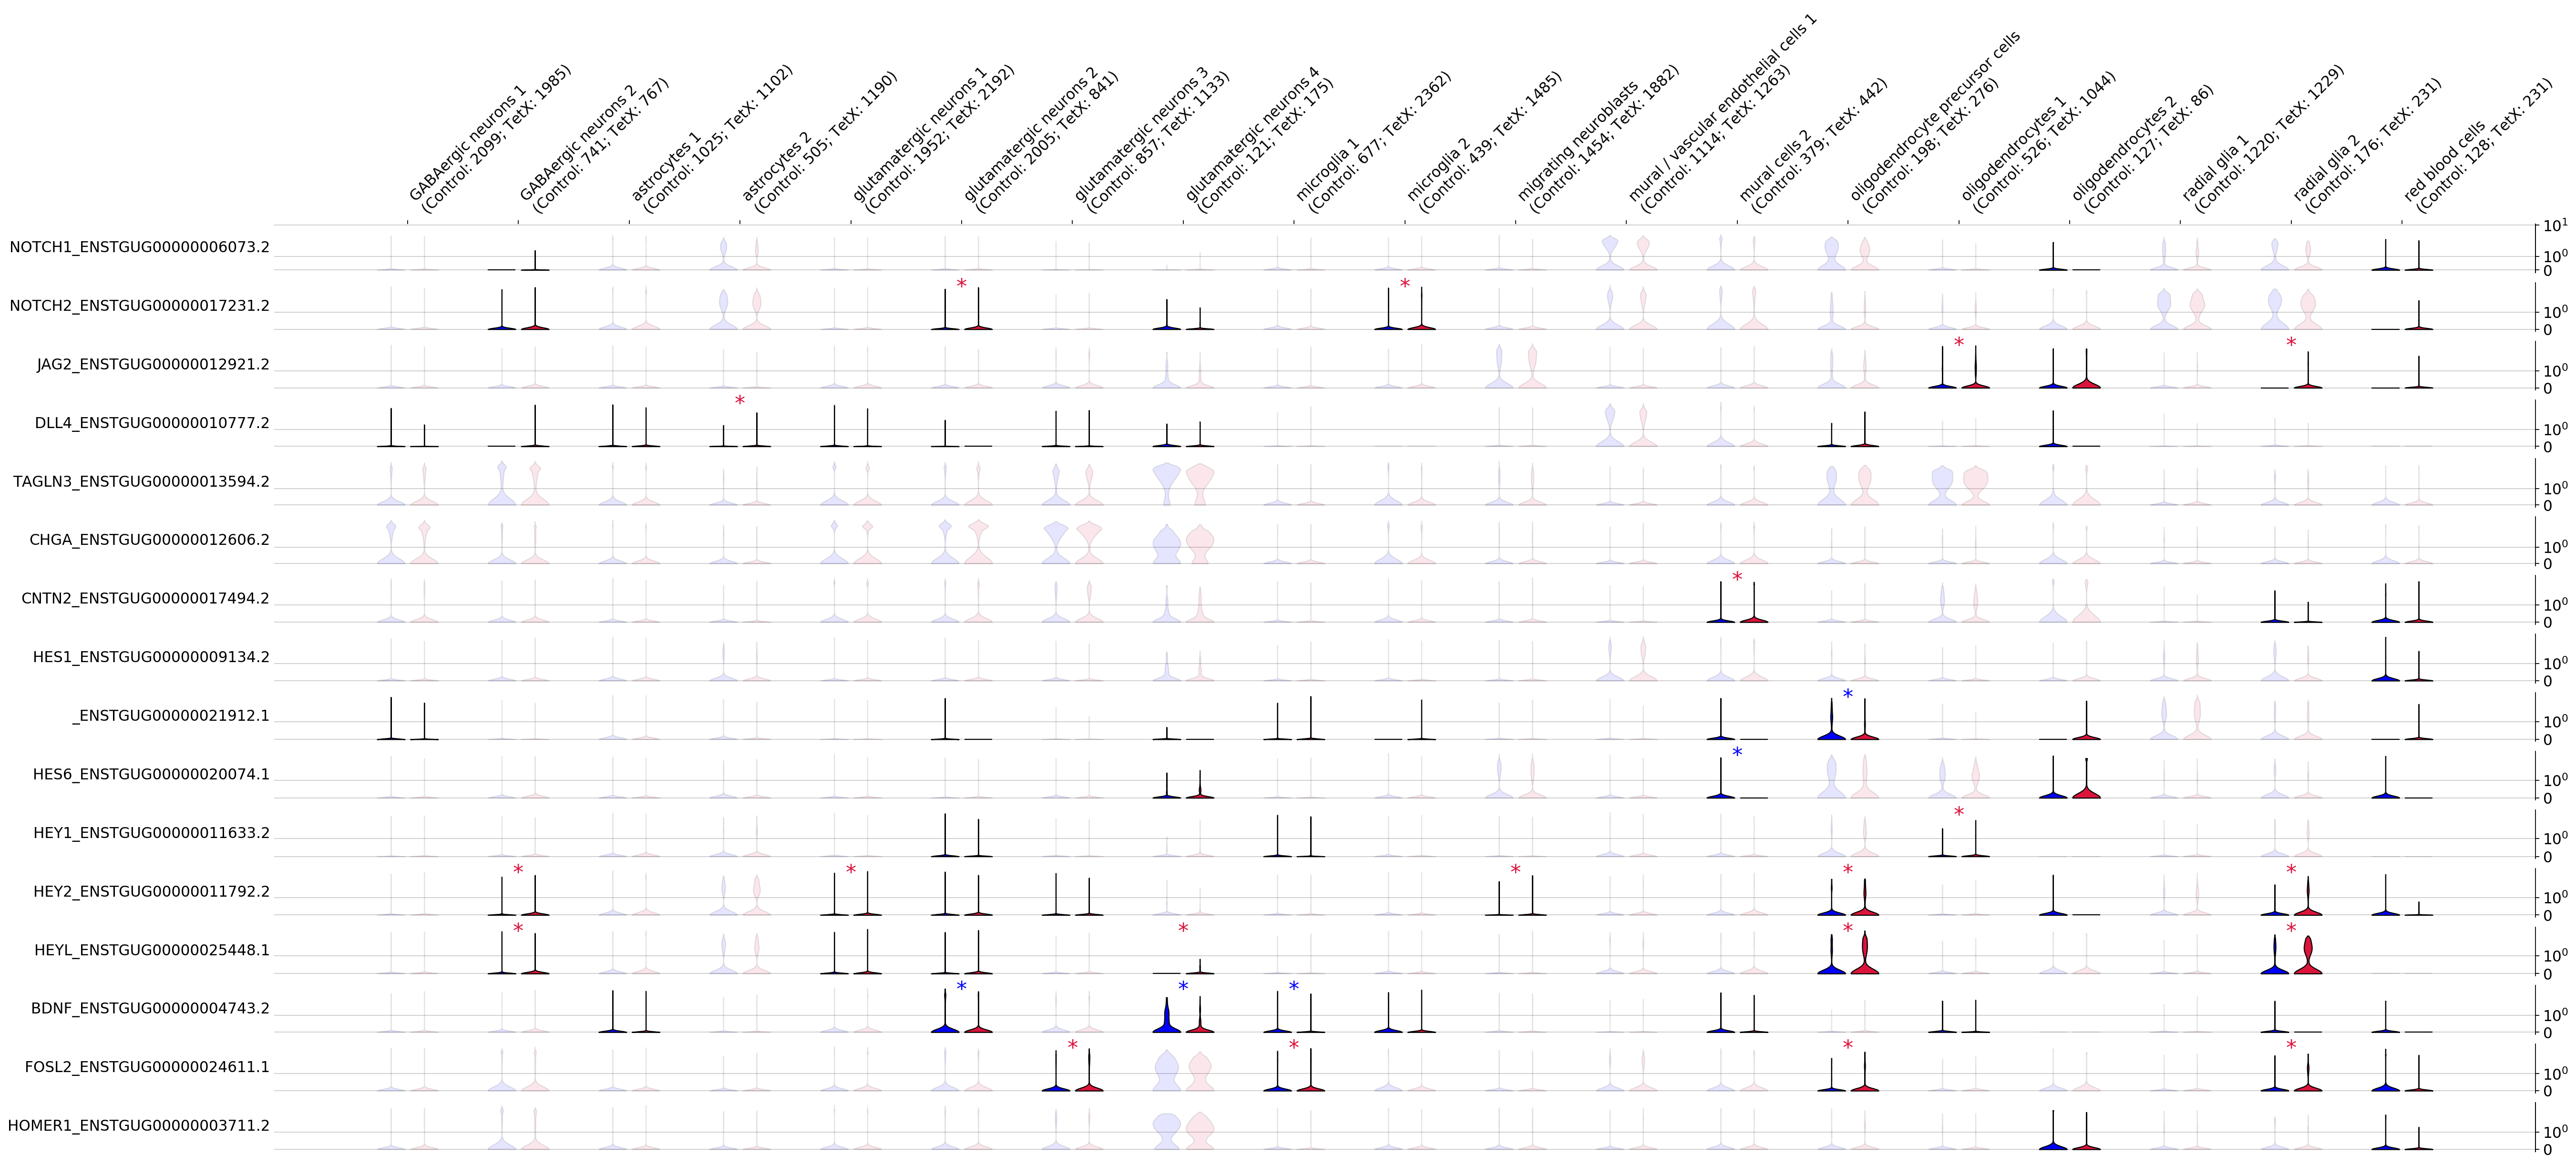

In [34]:
genes = markers
labels = markers
celltypes = celltypes_standard

violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    fig_name="mech_wave",
    fold_change_min=2,
)

___

# Plot correlation between genes

In [48]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

In [49]:
arrays = [notch_gene_idx, activity_gene_idx]
gene_indeces = cartesian(arrays)
gene_indeces

array([[12375,  8898],
       [12375,  4451],
       [12375,  6145],
       [16955,  8898],
       [16955,  4451],
       [16955,  6145],
       [12397,  8898],
       [12397,  4451],
       [12397,  6145],
       [   63,  8898],
       [   63,  4451],
       [   63,  6145],
       [ 4023,  8898],
       [ 4023,  4451],
       [ 4023,  6145],
       [18107,  8898],
       [18107,  4451],
       [18107,  6145]])

Plot relationships between Notch downstream target and activity genes in experiment GABAergic neurons:

In [50]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    chunk=[]
    for i in range(0, len(lst), n):
        chunk.append(lst[i:i + n])
        
    return chunk

In [51]:
# Split index list into chunks of 3 to allow matplotlib plot matrix to be filled in loop
indeces_subsets = chunks(gene_indeces, 3)

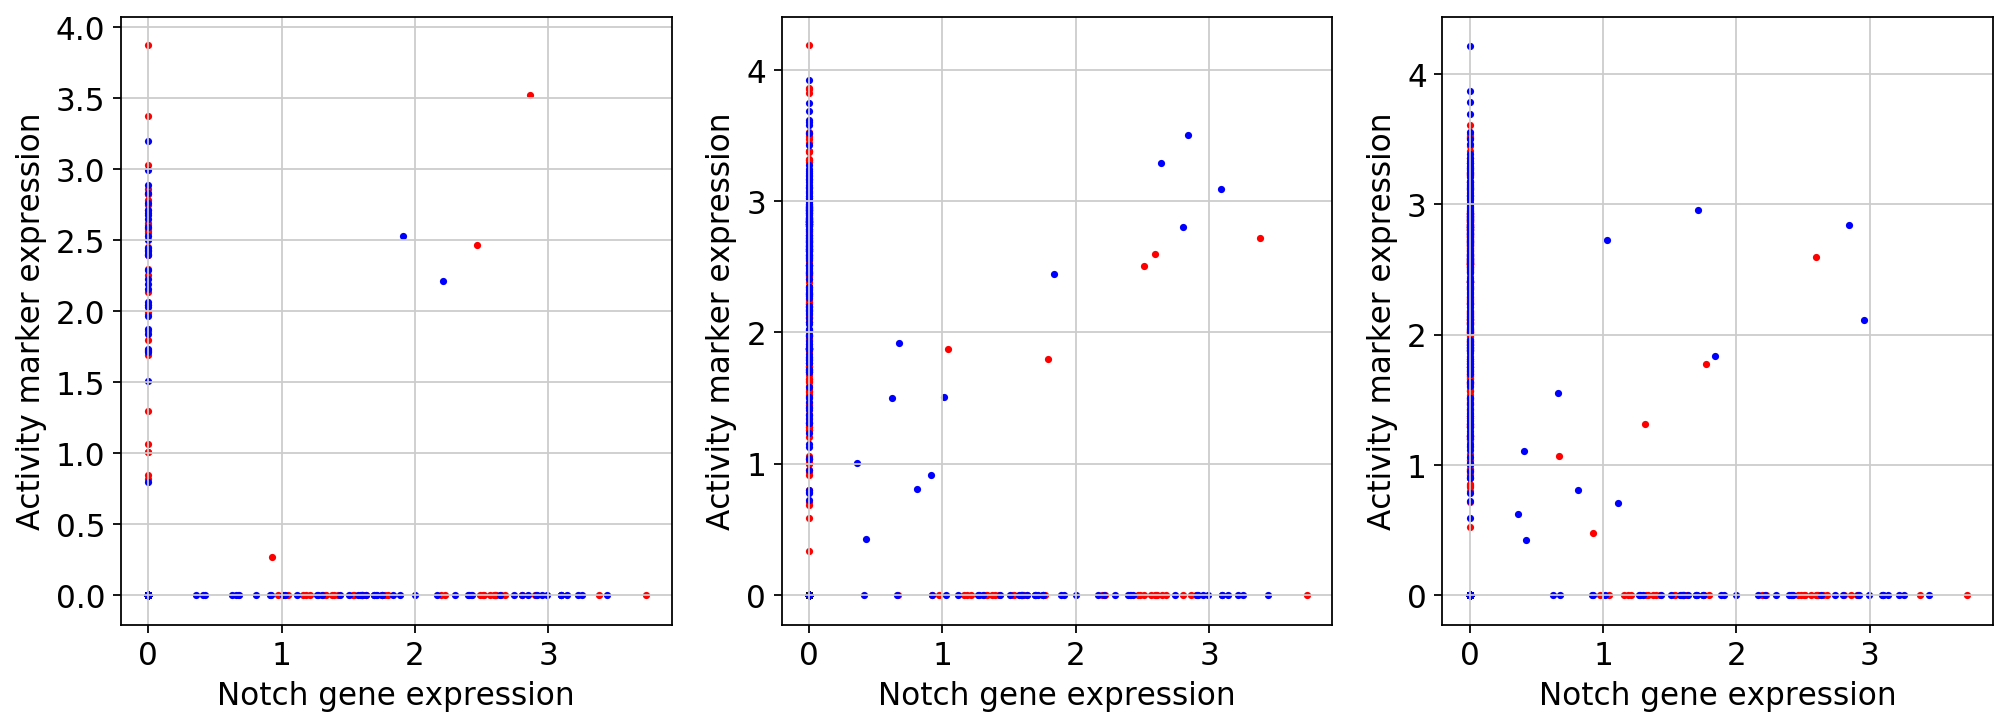

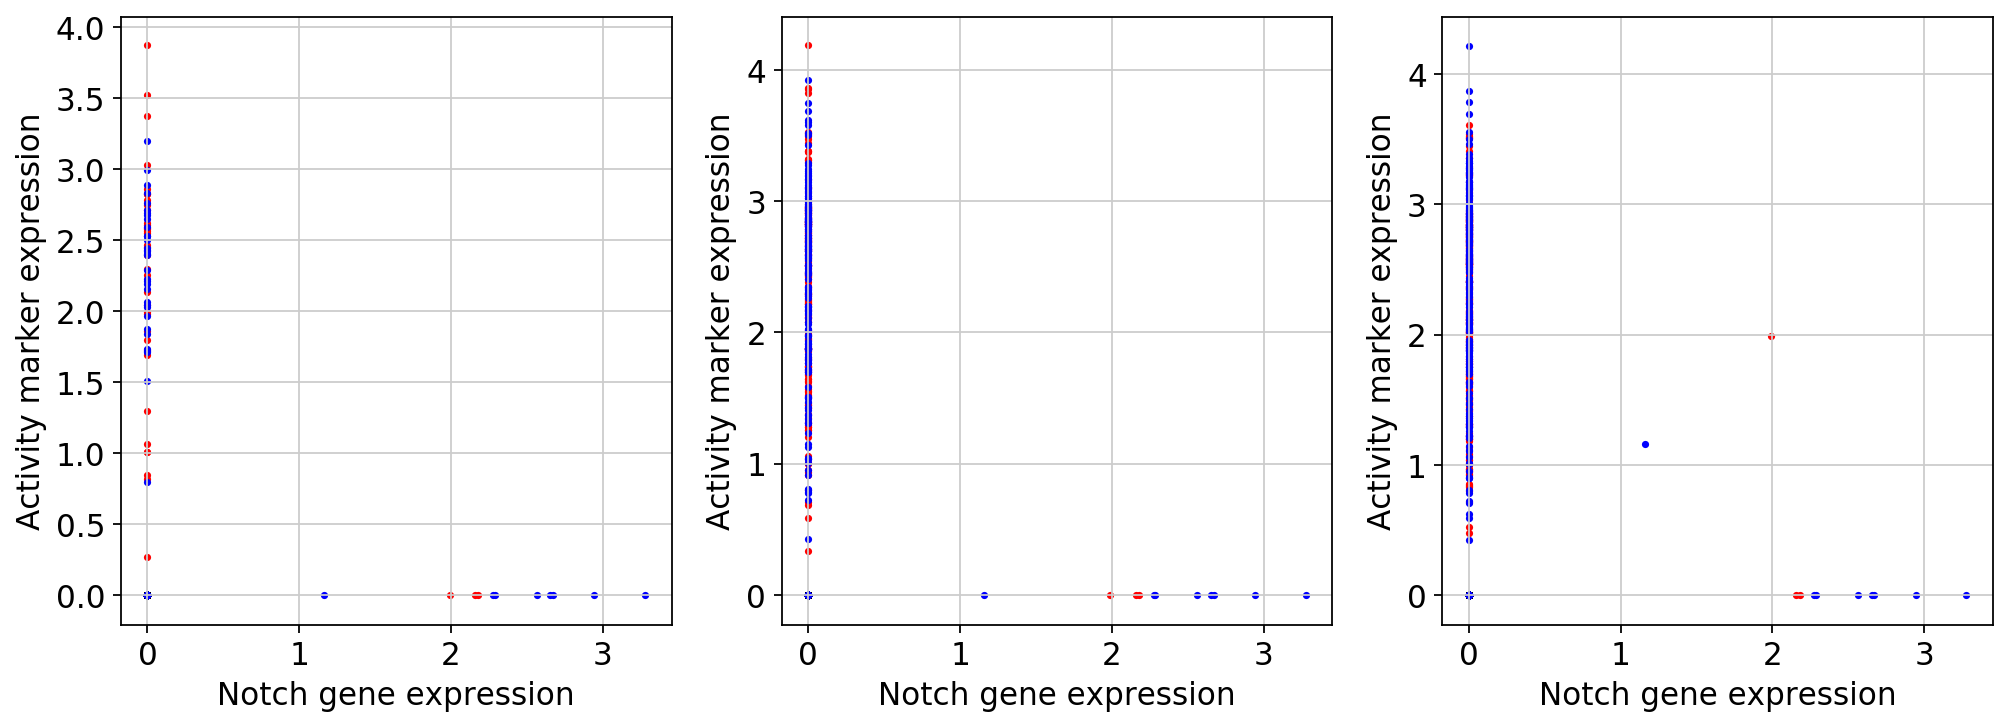

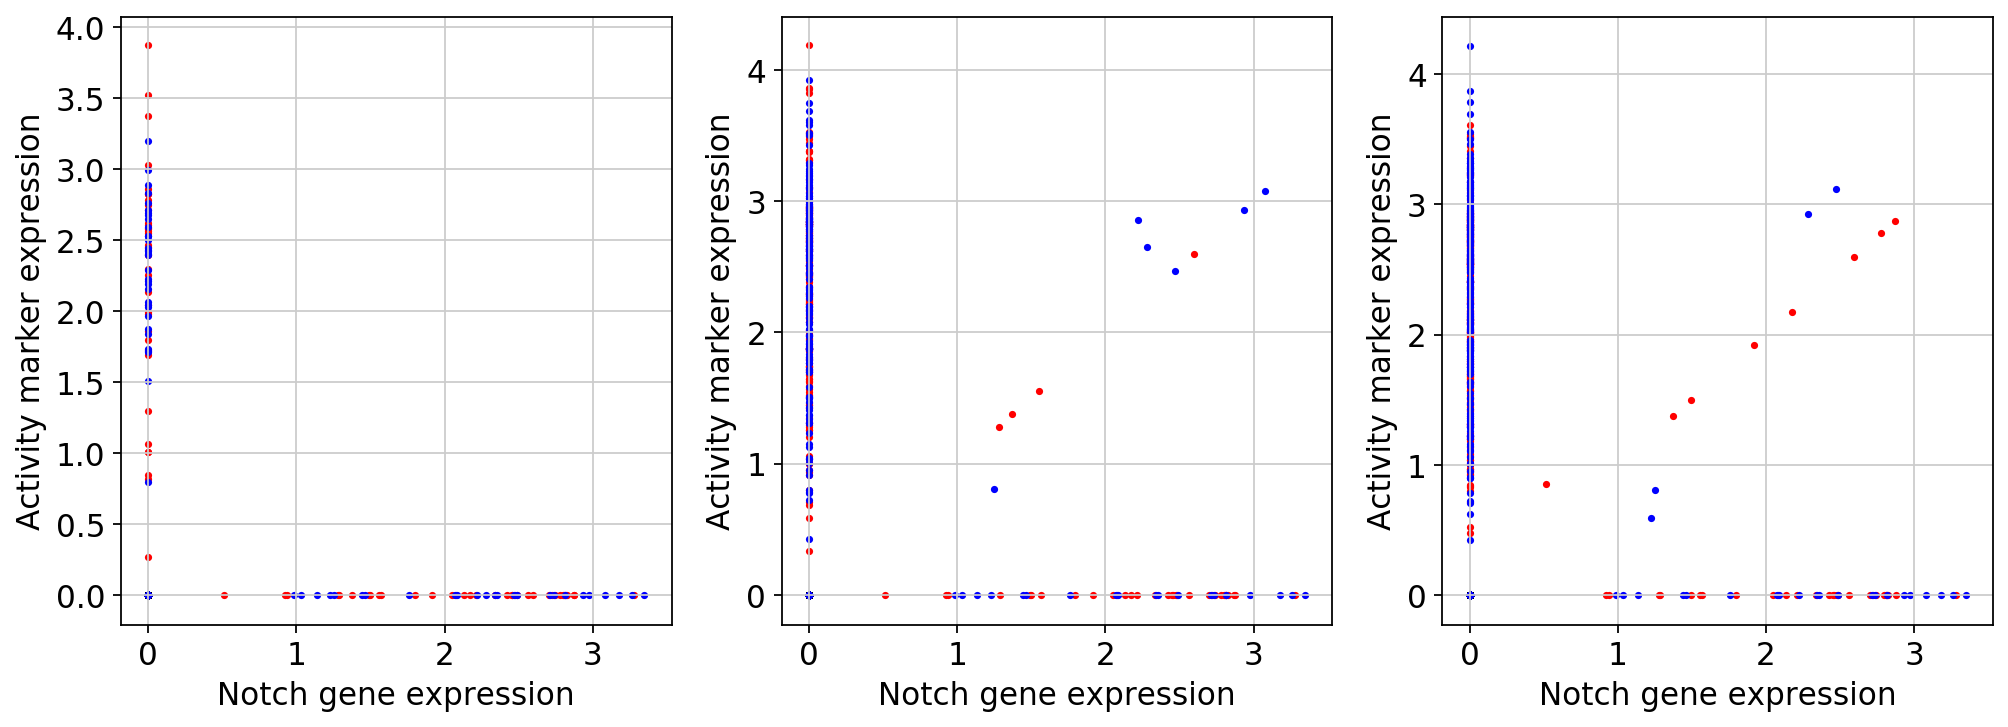

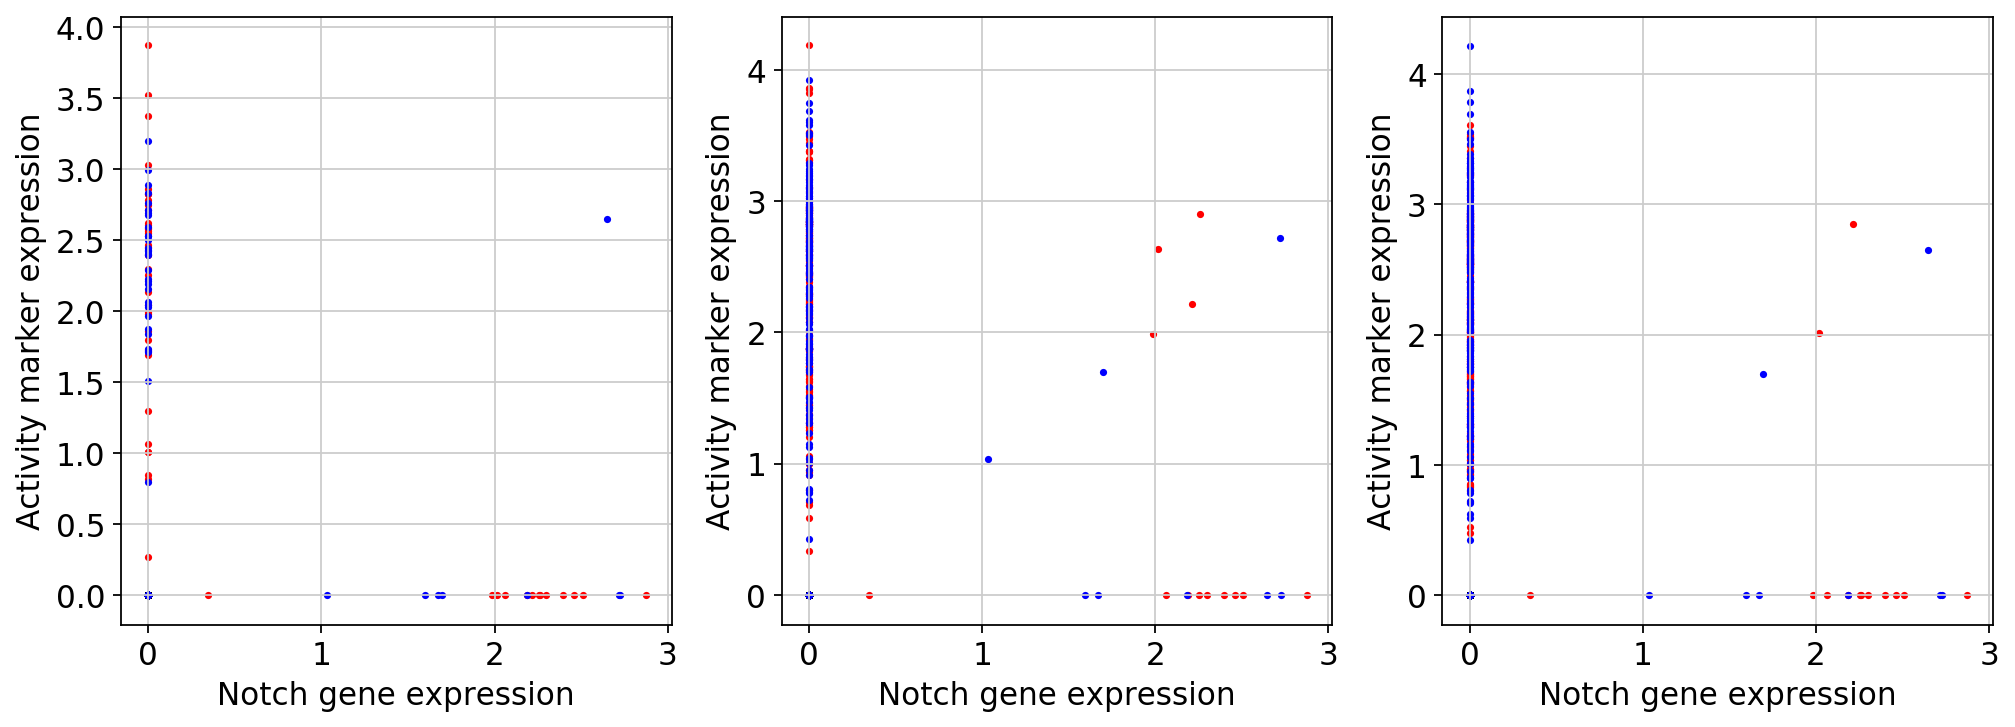

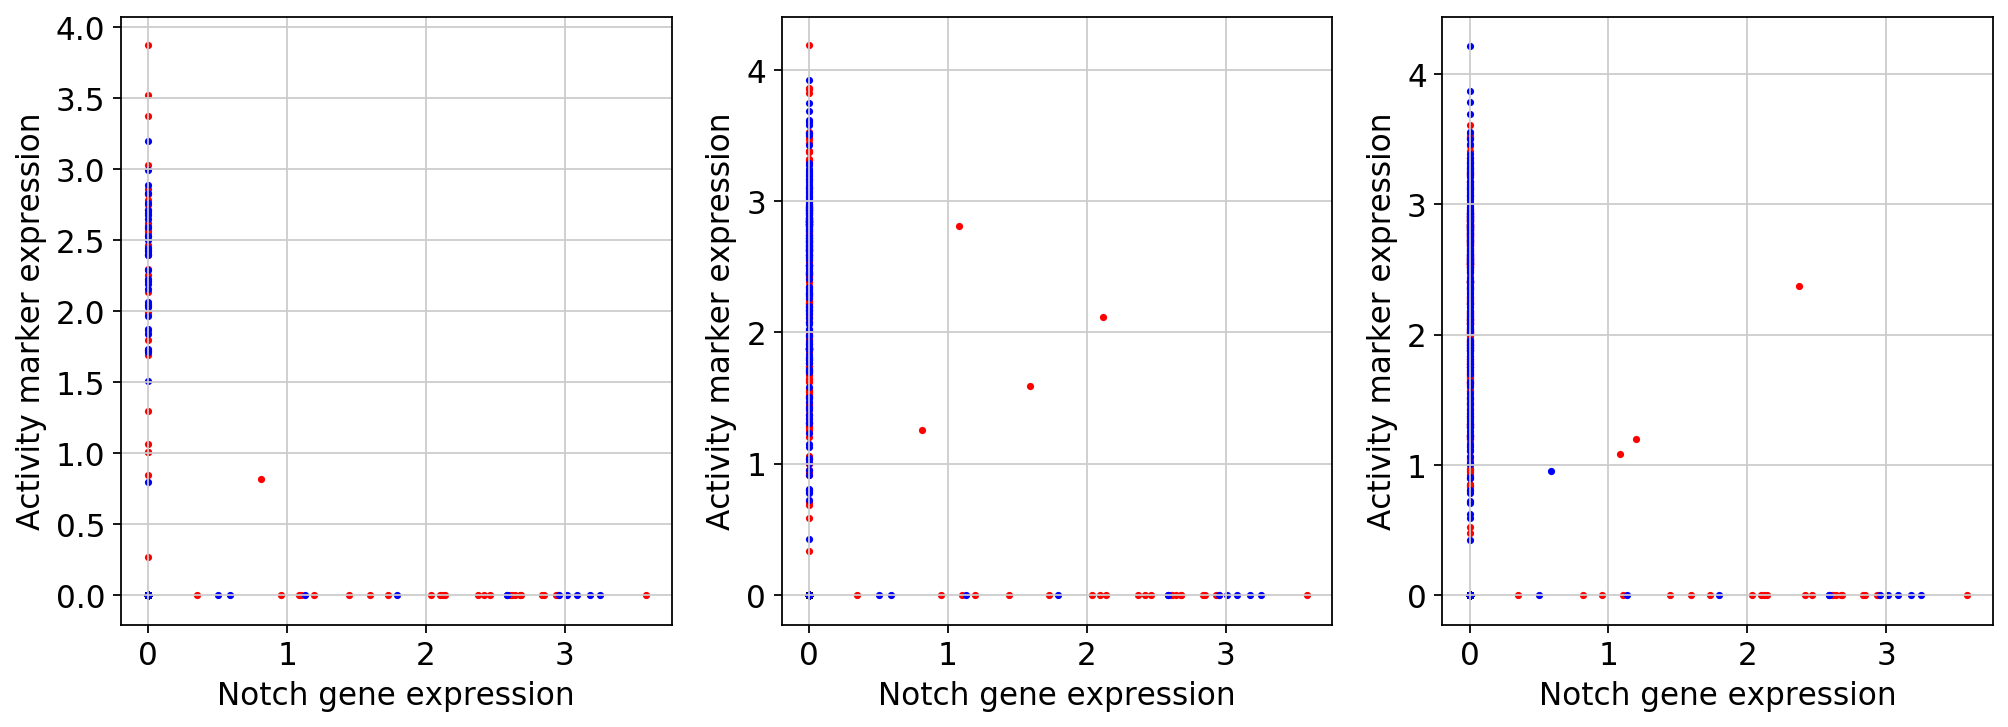

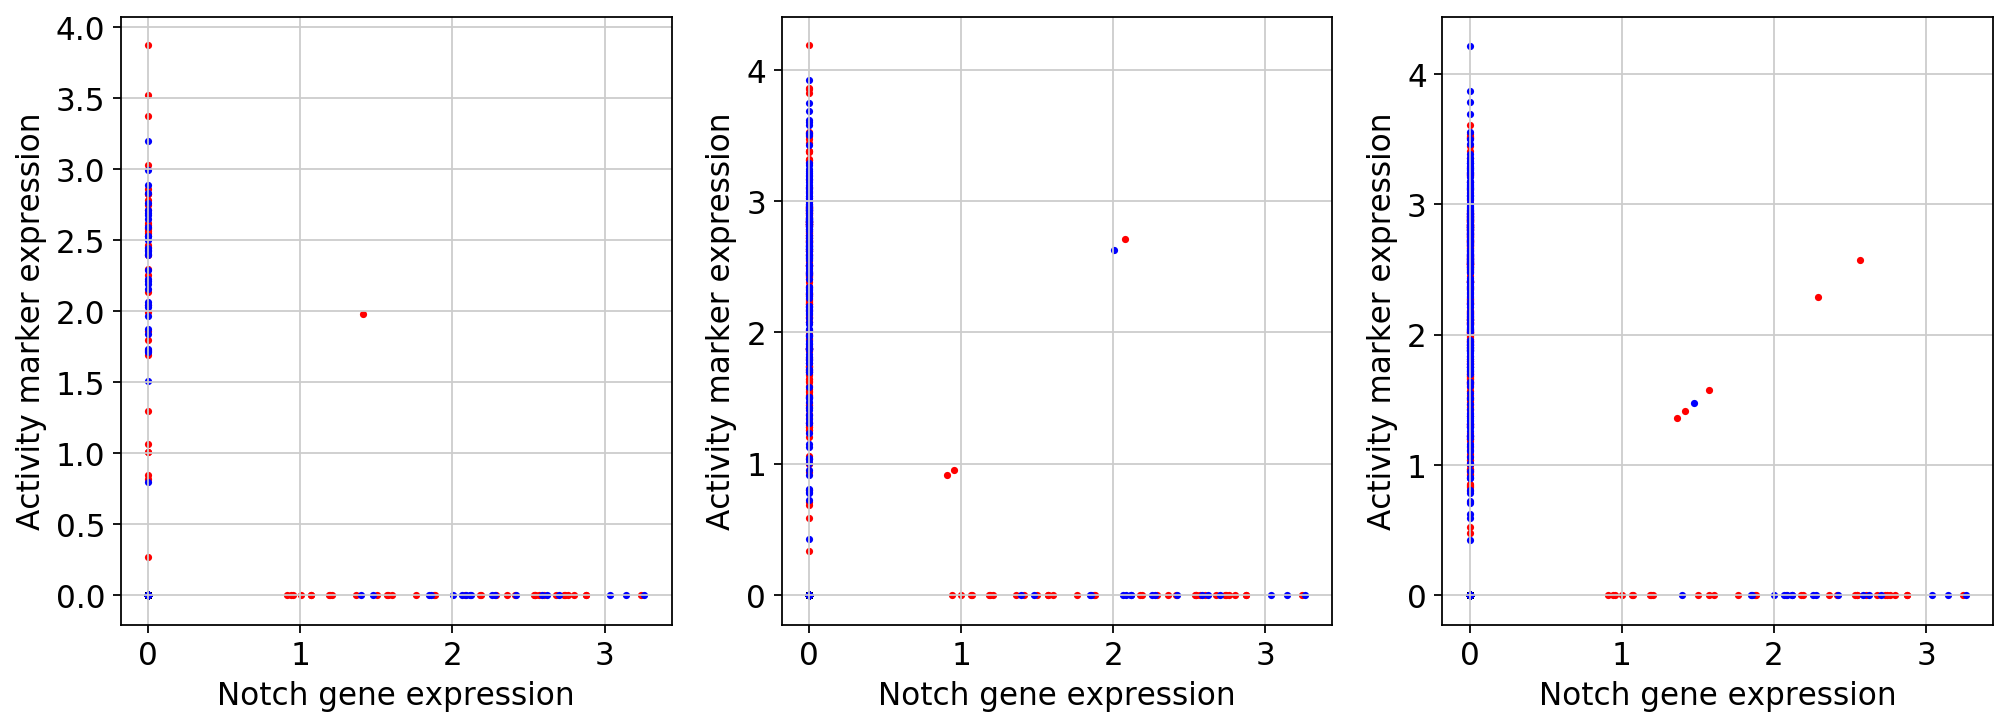

In [54]:
for subset in indeces_subsets:
    fig, axs = plt.subplots(figsize=(15,5), ncols=3)

    for ax, gene_index in zip(axs, subset):
        ax.scatter(adata_exp_gaba.X[:, gene_index[0]].toarray(), 
                   adata_exp_gaba.X[:, gene_index[1]].toarray(), 
                   s=5,
                   c="Red",
                   alpha=1)
        
        ax.scatter(adata_ctrl_gaba.X[:, gene_index[0]].toarray(), 
                   adata_ctrl_gaba.X[:, gene_index[1]].toarray(), 
                   s=5,
                   c="Blue",
                   alpha=1)

        ax.set_xlabel("Notch gene expression")
        ax.set_ylabel("Activity marker expression")

    fig.show()

___